In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
from scipy.stats import pearsonr,gaussian_kde, chi2
from scipy.optimize import root

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#SEED = 35010732 # from random.org
#np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [2]:
def correlated_ts(c,delta_t = 0.1,N=1000):
    # parameters for coupled oscillator
    K,D = 1.0,1.0
    data1 = langevin.time_series(A=1/K, D=D, delta_t=delta_t, N=N)
    data2 = langevin.time_series(A=1/(K+np.abs(c)), D=D, delta_t=delta_t, N=N)
    x1 = (data1 + data2)/2
    if c>0:
        x2 = (data1 - data2)/2
    else:
        x2 = (data2-data1)/2

    return x1,x2

def c_rho(rho):
    return 2*np.abs(rho)/(1-np.abs(rho))*np.sign(rho)


In [3]:
def calc_fundstats(x):
    return x[0]**2+x[-1]**2,np.sum(x[1:-1]**2),np.sum(x[0:-1]*x[1:])

In [4]:
def b(D,A,delta_t):
    return np.exp(-D/A*delta_t)

def q(aep,ass,ac,b):
    return (aep + (1+b**2)*ass - 2*b*ac)/(1-b**2)

def dqdB(aep,ass,ac,b):
    return 2*(b*aep+2*b*ass-(1+b**2)*ac)/(1-b**2)**2

def d2qdB2(aep,ass,ac,b):
    return (6*b+2)/(1-b**2)**3*(aep+2*ass)-(4*b**3+12*b)/(1-b**2)**3*ac

def dBdA(b,D,A,delta_t):
    return b*D*delta_t/A**2

def dBdD(b,A,delta_t):
    return -b*delta_t/A

def d2BdA2(b,D,A,delta_t):
    return b*D*delta_t/A**3*(D*delta_t/A-2)

def d2BdD2(b,A,delta_t):
    return b*delta_t**2/A**2

def d2BdAdD(b,D,A,delta_t):
    return b*delta_t/A**2*(1-D*delta_t/A)

def d2qdD2(aep,ass,ac,b,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdD(b,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdD2(b,A,delta_t)

def d2qdA2(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdA2(b,D,A,delta_t)

def d2qdAdD(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)+dqdB(aep,ass,ac,b)*d2BdAdD(b,D,A,delta_t)

#def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
#    return (N/2/A**2 - 
#            q(aep,ass,ac,b)/A**3 +
#            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2)) -
#            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A +
#           1/A**2*dqdB(aep,ass,ac,b)*dBdA(b,D,A,delta_t))

def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
    return (-N/2/A**2 + 
            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + 
                            dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2) +
                           2*b/A*dBdA(b,D,A,delta_t)) -
            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A)
        
def d2PdAdD(N,aep,ass,ac,b,D,A,delta_t):
    return (dqdB(aep,ass,ac,b)*dBdD(b,A,delta_t)/2/A**2 -
            d2qdAdD(aep,ass,ac,b,D,A,delta_t)/2/A +
            (N-1)/(1-b**2)*(b*d2BdAdD(b,D,A,delta_t) + dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2)/(1-b**2)))

def d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t):
    return ((N-1)/(1-b1**2)*(b1*d2BdD2(b1,A1,delta_t) + dBdD(b1,A1,delta_t)**2*(1+b1**2)/(1-b1**2))+
           (N-1)/(1-b2**2)*(b2*d2BdD2(b2,A2,delta_t) + dBdD(b2,A2,delta_t)**2*(1+b2**2)/(1-b2**2))-
           d2qdD2(a1ep,a1ss,a1c,b1,A1,delta_t)/2/A1 -
           d2qdD2(a2ep,a2ss,a2c,b2,A2,delta_t)/2/A2)
           
def phi_deriv(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    Q1 = q(a1ep,a1ss,a1c,b1)
    Q2 = q(a2ep,a2ss,a2c,b2)
    dQ1 = dqdB(a1ep,a1ss,a1c,b1)
    dQ2 = dqdB(a2ep,a2ss,a2c,b2)
    y1 = -N*A1**2/2 + A1*Q1/2 + b1*D*delta_t*(A1*b1*(N-1)/(1-b1**2)-dQ1/2)
    y2 = -N*A2**2/2 + A2*Q2/2 + b2*D*delta_t*(A2*b2*(N-1)/(1-b2**2)-dQ2/2)
    y3 = (b1*(N-1)/(1-b1**2)-dQ1/A1/2)*b1/A1 + (b2*(N-1)/(1-b2**2)-dQ2/A2/2)*b2/A2
    return np.array([y1,y2,y3])

def hessian(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    d2PdA2_1m = d2PdA2(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdA2_2m = d2PdA2(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    d2PdD2m = d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t)
    d2PdAdD_1m = d2PdAdD(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdAdD_2m = d2PdAdD(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    return np.array([[d2PdA2_1m,0,d2PdAdD_1m],[0,d2PdA2_2m,d2PdAdD_2m],[d2PdAdD_1m,d2PdAdD_2m,d2PdD2m]])

In [5]:
def d2PdA2N(N,b,A,delta_t):
    return -N/2/A - N/(1-b**2)**2*dBdA(b,D,A,delta_t)**2*(1+b**2+6*b/(1+b))+2*N*b/(1-b**2)*dBdA(b,D,A,delta_t)

def d2PdAdDN(N,b,D,A,delta_t):
    return N*b/(1-b**2)*dBdD(b,A,delta_t) - N/(1-b**2)**2*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2+6*b/(1+b))

def d2PdD2N(N,b1,b2,D,A1,A2,delta_t):
    return (-N/(1-b1**2)**2*dBdD(b1,A1,delta_t)**2*(1+b1**2+6*b1/(1+b1))-
            N/(1-b2**2)**2*dBdD(b2,A2,delta_t)**2*(1+b2**2+6*b2/(1+b2)))

In [6]:
corr1k = pd.read_csv("correlations1k025.csv")
corr1k

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,da1dd,dasdd,a1ep,a1ss,a1c,a2ep,a2ss,a2c,c,dc
0,0.25,0.666667,0.194775,1.061986,0.091293,0.708763,0.050445,1.055806,0.040420,0.000096,0.000052,0.000180,1.008469,1039.280680,767.195572,1.355117,696.269802,442.741641,0.505644,0.165415
1,0.25,0.666667,0.242435,1.064557,0.093026,0.642919,0.045430,0.993569,0.038005,0.000131,0.000004,0.000098,1.382940,1040.026703,784.177526,1.042398,634.210194,395.391353,0.663607,0.182666
2,0.25,0.666667,0.197538,0.903695,0.075013,0.591564,0.040648,0.935502,0.036080,-0.000009,0.000201,0.000110,1.642996,883.519893,649.085838,1.018106,584.104864,357.354085,0.534792,0.165560
3,0.25,0.666667,0.262963,0.989877,0.086681,0.565340,0.037789,0.986691,0.039849,-0.000028,0.000114,0.000040,2.651404,966.864772,714.530156,6.873631,549.034760,317.335266,0.758705,0.193440
4,0.25,0.666667,0.195444,0.910252,0.074297,0.630142,0.042540,1.027325,0.040115,-0.000054,0.000123,0.000128,1.003182,892.277825,630.622126,2.539469,618.040653,379.545674,0.451139,0.154183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.25,0.666667,0.176095,0.931689,0.076676,0.644054,0.045223,0.985231,0.037024,0.000061,0.000098,0.000107,1.140963,910.803950,668.096961,1.009620,637.863178,393.441106,0.453496,0.155165
496,0.25,0.666667,0.246368,0.988886,0.083792,0.594420,0.039482,1.015197,0.039741,-0.000123,0.000086,0.000055,1.008091,966.887217,705.849909,1.107346,585.410790,349.701045,0.671205,0.182495
497,0.25,0.666667,0.276271,1.045932,0.092495,0.584848,0.039075,0.957601,0.035594,-0.000100,0.000127,0.000009,1.679137,1017.602568,778.800295,1.108266,579.558938,343.878074,0.796559,0.201097
498,0.25,0.666667,0.272114,1.089475,0.098240,0.618990,0.043245,0.958458,0.035200,0.000036,-0.000059,0.000064,5.487223,1056.204521,798.719411,1.079226,608.343109,384.420666,0.768384,0.199741


In [7]:
rho = 0.25
delta_t = 0.3
N = 1000
c = 2*rho/(1-rho)
guessa1 = 1.0
guessa2 = 1.0/(1.0+c)
guessd = 1.0
A1_list = []
A2_list = []
dA1_list = []
dA2_list = []
dA1dA2_list = []
dA1dD_list = []
dA2dD_list = []
C_list = []
dC_list = []
D_list = []
dD_list = []
tau1_list = []
dtau1_list = []
tau2_list = []
dtau2_list = []
print(guessa1,guessa2,guessd,c)
for index, row in corr1k.iterrows():
    a1ep,a1ss,a1c = row['a1ep'], row['a1ss'], row['a1c']
    a2ep,a2ss,a2c = row['a2ep'], row['a2ss'], row['a2c']
    para = (a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    result = root(phi_deriv, [guessa1,guessa2,guessd],jac=hessian,args=para)
    A1 = result.x[0]
    A2 = result.x[1]
    D = result.x[2]
    # lets calculate the Hessian
    h = hessian([A1,A2,D],a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    var = -np.linalg.inv(h)
    dA1 = np.sqrt(var[0,0])
    dA2 = np.sqrt(var[1,1])
    dD = np.sqrt(var[2,2])
    dA1A2 = var[0,1]
    dA1dD = var[0,2]
    dA2dD = var[1,2]
    C = (A1-A2)/A2
    dC = np.sqrt(1/A2**2*dA1**2+A1**2/A2**4*dA2**2-A1/A2**4*dA1A2)
    tau1 = A1/D
    tau2 = A2/D
    dtau1 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
    dtau2 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA2dD)
    print(A1,dA1,A2,dA2,D,dD,C,dC)
    # add results to list
    A1_list.append(A1)
    A2_list.append(A2)
    dA1_list.append(dA1)
    dA2_list.append(dA2)
    D_list.append(D)
    dD_list.append(dD)
    dA1dA2_list.append(dA1A2)
    dA1dD_list.append(dA1dD)
    dA2dD_list.append(dA2dD)
    C_list.append(C)
    dC_list.append(dC)
    tau1_list.append(tau1)
    tau2_list.append(tau2)
    dtau1_list.append(dtau1)
    dtau2_list.append(dtau2)



1.0 0.6000000000000001 1.0 0.6666666666666666
1.0390272773576963 0.04684042917999925 0.6975848248863001 0.030555787780405547 1.0549195999693601 0.03466478259994725 0.48946370432735276 0.08164067434848613
1.0411810100592709 0.04714987495949282 0.6344344775820867 0.02771168971687193 0.9917761941426039 0.03259292386292384 0.6411166902961338 0.08861161200542665
0.8866257303426377 0.039948252600000116 0.5834340321504812 0.0254567189418656 0.9344918837077572 0.03081901350973755 0.5196674884984364 0.08072994962427059
0.9717109856118633 0.04395993022879072 0.5575383673504636 0.024213304941267715 0.9999415448694325 0.03317530840570286 0.7428594021782443 0.09221710858147686
0.8917116537395872 0.03995759063892181 0.6221251040559731 0.027151326751858412 1.0245231450567944 0.03392005715389218 0.43333173332185476 0.07707269636396766
0.895269099720779 0.0402636851644082 0.5629592537444223 0.02442677400908903 0.997626583991514 0.0331321521079853 0.5902911156820984 0.08399032888259378
0.912178686621405

1.01712654761559 0.04606210368667469 0.5625271051359088 0.02431399278029044 1.0398654716047067 0.034543864298401346 0.8081378449663296 0.09565803268471257
0.9291429456579642 0.04180532325638838 0.6163362628457301 0.02683250530583842 1.0242808596265376 0.03388474038665084 0.5075260075854569 0.08094966215961828
0.960469860425944 0.04334476201695162 0.6020380166051983 0.02629793819360839 0.96311958119592 0.03172586028213925 0.5953641363744583 0.08531387360274009
1.0329671699490905 0.04682121474119248 0.5765840737242969 0.02503288718407812 1.0038416293588808 0.033192342127894285 0.7915291403678637 0.09519164587349926
1.0510367094459196 0.0476328494313458 0.5800841671205759 0.02517739211019902 1.015466500107597 0.03358229746951622 0.8118693269341584 0.09636013652236917
1.0369347437604024 0.04704893139982889 0.5803697271977288 0.02530068059308187 0.956965227863314 0.03151698022697075 0.7866795857309151 0.09502727434780575
1.1796891546121364 0.05368211663869139 0.6318048921695003 0.0275731288

0.9709431061425507 0.04380250528444943 0.5857344952346588 0.02549311209646224 1.0041107067040689 0.03322417856621786 0.6576505465220526 0.08830137678093863
0.9574661341117373 0.04323798879717449 0.564239111918777 0.024469487342422398 0.9981794641416231 0.03308797747521998 0.6969155698117679 0.08970451522891491
1.0806267432436594 0.04900834735654386 0.6146054646365049 0.02673913472737616 1.0223913832664606 0.03369894446347516 0.7582446063716219 0.09446127400605328
0.955930994601159 0.04306016122983384 0.6536554006781421 0.02864821794015107 0.9818488521128839 0.032263012043965665 0.46243876147801694 0.07929812495547789
0.8974851601600792 0.040265952575541934 0.5875693999607731 0.02553175983793259 1.0305210255274522 0.03423544518365302 0.5274538807160423 0.08132624736363123
0.9519377790002216 0.042710287191033675 0.6563346261449636 0.028715682390143125 1.0444521750124065 0.03447532243457027 0.45038482060821294 0.0787051422727664
0.9816192007785898 0.044417168356811955 0.588850903336567 0.

1.0477345612005025 0.04749291031344931 0.6008146931379211 0.026203947229752944 0.9804039491568066 0.032279472732112346 0.7438564222329825 0.09332705123781666
0.9563646728433784 0.04314024886998121 0.6395075824211724 0.028066815153452346 0.958027590720781 0.031462490881304504 0.4954704199480899 0.08089460661132308
1.0781335162153827 0.04884467005165486 0.6425478897166078 0.02803446468890934 1.0218160437574142 0.033604063995764245 0.6779037538990089 0.0908095497675616
1.0491815038582568 0.0477257879027886 0.5892941610955947 0.02567045611572592 0.949787536744289 0.03122689279483817 0.7804036983968344 0.09493855778038865
0.9449969866470779 0.042591005140189375 0.6773286171404238 0.029768057454128038 0.9593082783353376 0.03143324280176802 0.3951824309988678 0.07609343158442443
1.096596065102803 0.04985542049558399 0.5832795283547525 0.02530372376529054 1.0099347661521247 0.033341829602189614 0.8800523793385215 0.10009674103206934
1.0734891710209755 0.0487387155049065 0.5620810219232171 0.02

0.9526963381152327 0.04297432767688339 0.6502533442429 0.028448943976203657 1.0233056231479627 0.03374595519429277 0.46511563000798045 0.07963262898726588
1.0496221329176394 0.047501299460911396 0.6080817297855767 0.026457048238039113 1.0298661598551457 0.03400861434793773 0.7261201603405512 0.09259192779686033
0.946543406761923 0.04252154796569723 0.6254189122795999 0.027234803132108357 1.0508277398925752 0.034791204766880156 0.5134550429756769 0.0814562596040444
1.1053919011086548 0.050167511521932495 0.5695992011311164 0.02460898721401832 1.077452961329388 0.03581006403102122 0.9406486155766289 0.10305416791820479
1.1621187687148322 0.052892270067564646 0.6962182137547676 0.03055786167203416 1.012325575091904 0.033106623959155715 0.6691875417154357 0.09177106839379538
0.9694248006946112 0.04372055738810591 0.6740326543270673 0.029589618910516757 0.988123020703426 0.032430995921339786 0.43824604708870385 0.0784714836787642
0.9430994161678562 0.04255937402806599 0.5989531308122713 0.0

1.1694352209129397 0.05337285237404711 0.593987733662349 0.025754892398363708 1.0084307824629168 0.033209027329442864 0.9687868193886012 0.10515158919668578
0.9250229163918463 0.04163340809115757 0.6090830404752912 0.026576988182402058 0.9862368753114945 0.032554345407662846 0.5187139600373949 0.08135363473128285
0.9231648306718594 0.04166300909953093 0.5380900938869433 0.023325398822392786 0.975398316874215 0.032395099005266735 0.7156324585039158 0.08990827460507142
0.9677622640975977 0.043728425956766445 0.6155008474827124 0.02684209331420834 0.9737184130972524 0.032053755056828295 0.5723167044457713 0.08435712832695255
0.9311221341118876 0.04196289926202959 0.5898079665518235 0.025659914877354084 1.0094886858913237 0.03343947907808145 0.5786869403536183 0.0842362475924589
1.0645998753229577 0.048352180788423224 0.5454258546689904 0.023575497418128137 1.0223119604773097 0.03394608606927663 0.951869105964999 0.10273919463482216
1.0339150935634638 0.046759150038210295 0.592253349850352

1.029332112293043 0.046702014102010435 0.5508619599661018 0.0238650586255505 0.9895453884324329 0.032770648563113354 0.8685844859506812 0.09841013113744285
1.0868726124651753 0.049169047474088845 0.6508930807232919 0.028371963479160187 1.060310704553837 0.03493515077290448 0.6698174318544144 0.0905791263432185
1.101233890252414 0.05012151559495188 0.5656832294854162 0.024502104817954867 1.0035963625730764 0.03317186013430929 0.9467324340765254 0.10308001694211678
0.9753889663122091 0.044094200488975124 0.6170258191048531 0.026992046788591628 0.9510963100759294 0.03125258685579628 0.5807911696908394 0.08491531118938901
0.9695960108052911 0.0438523845991723 0.6152396638475895 0.02683565470981609 0.9750659395734718 0.03210311099057031 0.5759647301372374 0.08463367646428477
1.0662660559199617 0.04833439581339486 0.5966950419766496 0.02593295577489543 1.0322500089349749 0.034119512482255775 0.7869531015169519 0.09562879391981556
0.9915528900194606 0.04479308385599006 0.5465623214123635 0.02

0.9854826461385715 0.044521601201022415 0.6094578696861923 0.026581463866526083 0.9926383599874854 0.03273134906479217 0.6169823955936331 0.08672674042605702
0.9618135666653537 0.04357941115726299 0.506730366872707 0.021816603428873992 0.993745073460637 0.03314632184556351 0.8980776159147487 0.09831124422674298
1.0328458580117768 0.04687363435775189 0.6483265717379201 0.02842921738653619 0.9573103473351975 0.03136476387184926 0.5930950589347355 0.0864843015332922
0.8581541965262532 0.03843113534490719 0.5767287377815984 0.02505314683665995 1.0183737177995584 0.03387873148472626 0.4879685028825943 0.07892901648794863
1.1212583242936962 0.05109580788804578 0.5937597134954107 0.025859834603282013 0.9649356590026716 0.031708924508225676 0.8884041790119913 0.10086840134594498
1.0113109314404418 0.0457785384421685 0.5636881797177421 0.02447054903387711 0.9972371636160022 0.03301776715935499 0.7940963955405979 0.09492083134682644
0.9415185882216077 0.04257008865629833 0.5769249177136292 0.025

0.9319839189092916 0.04203149196251688 0.6224633290132803 0.027222302775997142 0.9665890701154575 0.03181941251603802 0.49725112383191916 0.08057199265408867
0.9993376236785959 0.04509801633326176 0.5935961247237262 0.025743808812116277 1.0535520060963135 0.034940801923870425 0.6835312463397759 0.08988229705553968
1.0796138787708593 0.04885256631694747 0.6390007334298924 0.0278633419607347 1.043050699899639 0.034364387033447734 0.6895346472858291 0.09138552952254796
0.8573627956745943 0.03837273915942209 0.6135207965064896 0.026792059530422945 1.0042430741642243 0.033257724825224495 0.39744699862920685 0.07495113803697728
1.0684545903844729 0.04850788458797566 0.586023426568193 0.025472908250673342 0.9934976574487697 0.032769292235527235 0.8232284614310407 0.0971290756297124
1.010870232718087 0.04577691727971974 0.6121641415921575 0.026744020683947024 0.9599514902687207 0.03155082371853814 0.6513058574273037 0.08859956434203677
0.8940027126955549 0.04019253343373717 0.5354994184963123 

In [8]:
corr1k['A1'] = A1_list
corr1k['A2'] = A2_list
corr1k['dA1'] = dA1_list
corr1k['dA2'] = dA2_list
corr1k['D'] = D_list
corr1k['dD'] = dD_list
corr1k['dA1dA2'] = dA1dA2_list
corr1k['dA1dD'] = dA1dD_list
corr1k['dA2dD'] = dA2dD_list
corr1k['C'] = C_list
corr1k['dC'] = dC_list
corr1k['tau1'] = tau1_list
corr1k['tau2'] = tau2_list
corr1k['dtau1'] = dtau1_list
corr1k['dtau2'] = dtau2_list

In [9]:
corr1k

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,...,dD,dA1dA2,dA1dD,dA2dD,C,dC,tau1,tau2,dtau1,dtau2
0,0.25,0.666667,0.194775,1.061986,0.091293,0.708763,0.050445,1.055806,0.040420,0.000096,...,0.034665,0.000479,0.000972,0.000592,0.489464,0.081641,0.984935,0.661268,0.267298,0.267926
1,0.25,0.666667,0.242435,1.064557,0.093026,0.642919,0.045430,0.993569,0.038005,0.000131,...,0.032593,0.000437,0.000926,0.000501,0.641117,0.088612,1.049814,0.639695,0.288904,0.289688
2,0.25,0.666667,0.197538,0.903695,0.075013,0.591564,0.040648,0.935502,0.036080,-0.000009,...,0.030819,0.000336,0.000734,0.000434,0.519667,0.080730,0.948778,0.624333,0.276978,0.277564
3,0.25,0.666667,0.262963,0.989877,0.086681,0.565340,0.037789,0.986691,0.039849,-0.000028,...,0.033175,0.000342,0.000875,0.000431,0.742859,0.092217,0.971768,0.557571,0.272850,0.273640
4,0.25,0.666667,0.195444,0.910252,0.074297,0.630142,0.042540,1.027325,0.040115,-0.000054,...,0.033920,0.000352,0.000801,0.000506,0.433332,0.077073,0.870368,0.607234,0.248764,0.249256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.25,0.666667,0.176095,0.931689,0.076676,0.644054,0.045223,0.985231,0.037024,0.000061,...,0.032430,0.000379,0.000792,0.000503,0.437820,0.077550,0.928580,0.645825,0.265549,0.266070
496,0.25,0.666667,0.246368,0.988886,0.083792,0.594420,0.039482,1.015197,0.039741,-0.000123,...,0.033561,0.000362,0.000876,0.000465,0.647322,0.087705,0.953535,0.578839,0.267042,0.267755
497,0.25,0.666667,0.276271,1.045932,0.092495,0.584848,0.039075,0.957601,0.035594,-0.000100,...,0.031513,0.000387,0.000884,0.000434,0.770847,0.093995,1.068677,0.603483,0.298388,0.299266
498,0.25,0.666667,0.272114,1.089475,0.098240,0.618990,0.043245,0.958458,0.035200,0.000036,...,0.031811,0.000431,0.000931,0.000469,0.740303,0.093562,1.099153,0.631587,0.302545,0.303438


In [10]:
# display statistics
print(corr1k['A1'].mean(),corr1k['A1'].std(),corr1k['dA1'].mean(),corr1k['dA1'].std())
print(corr1k['a1'].mean(),corr1k['a1'].std(),corr1k['da1'].mean(),corr1k['da1'].std())
print(corr1k['A2'].mean(),corr1k['A2'].std(),corr1k['dA2'].mean(),corr1k['dA2'].std())
print(corr1k['a2'].mean(),corr1k['a2'].std(),corr1k['da2'].mean(),corr1k['da2'].std())
print(corr1k['C'].mean(),corr1k['C'].std(),corr1k['dC'].mean(),corr1k['dC'].std())
print(corr1k['c'].mean(),corr1k['c'].std(),corr1k['dc'].mean(),corr1k['dc'].std())

1.0016334656597157 0.08321579676671188 0.04530220268550651 0.003981684160607868
1.0233069103872536 0.08693840636360192 0.08873207903929213 0.011688058216342131
0.6004359345978609 0.039178729815922325 0.026145636109716305 0.001812947059806461
0.6081941672472146 0.04016943504707638 0.04099611947148186 0.0040399435648113624
0.6746636310691131 0.17132064859994697 0.08948930317809049 0.008650599931843098
0.6967428144414719 0.17646317694404148 0.18543454238494944 0.023141245312438396


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


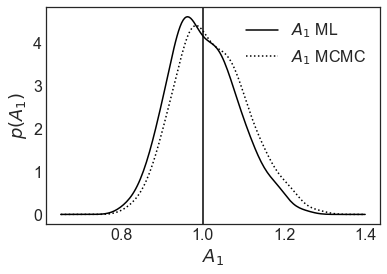

In [11]:
plt.figure(facecolor="white")
xs = np.linspace(0.65,1.4,200)
densityA1 = gaussian_kde(corr1k['A1'])
densitya1 = gaussian_kde(corr1k['a1'])
plt.plot(xs,densityA1(xs),"k-",label=r"$A_{1}$ ML")
plt.plot(xs,densitya1(xs),"k:",label=r"$A_{1}$ MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A_1$")
plt.ylabel(r"$p(A_{1})$")
plt.savefig("A1kde025.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


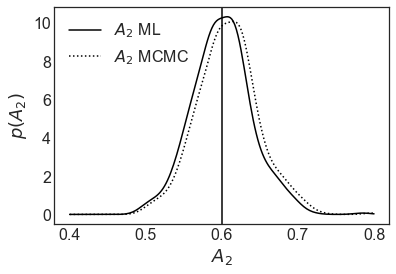

In [12]:
plt.figure(facecolor="white")
xs = np.linspace(0.4,0.8,200)
densityA2 = gaussian_kde(corr1k['A2'])
densitya2 = gaussian_kde(corr1k['a2'])
plt.plot(xs,densityA2(xs),"k-",label=r"$A_{2}$ ML")
plt.plot(xs,densitya2(xs),"k:",label=r"$A_{2}$ MCMC")
plt.axvline(x=0.6,color="k")
plt.legend()
plt.xlabel(r"$A_2$")
plt.ylabel(r"$p(A_{2})$")
plt.savefig("A2kde025.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [13]:
# display statistics
print(corr1k['dA1dA2'].mean(),corr1k['dA1dA2'].std(),corr1k['dA1dD'].mean(),corr1k['dA2dD'].mean())
print(corr1k['da1da2'].mean(),corr1k['dA1dA2'].std(),corr1k['da1dd'].mean(),corr1k['dasdd'].mean())

0.00038962228800473796 5.061276008815563e-05 0.0009010717272033384 0.00047361953079183664
3.330674271047126e-06 5.061276008815563e-05 8.480669983066197e-05 8.126721115871771e-05


(array([ 2.,  1.,  3.,  9.,  9., 19., 28., 29., 20., 43., 36., 37., 40.,
        29., 33., 33., 27., 22., 14., 12., 15.,  7.,  9.,  7.,  8.,  3.,
         2.,  0.,  1.,  2.]),
 array([0.06062395, 0.06281332, 0.06500269, 0.06719206, 0.06938143,
        0.0715708 , 0.07376017, 0.07594954, 0.07813891, 0.08032828,
        0.08251765, 0.08470702, 0.08689639, 0.08908576, 0.09127513,
        0.0934645 , 0.09565387, 0.09784324, 0.10003261, 0.10222198,
        0.10441134, 0.10660071, 0.10879008, 0.11097945, 0.11316882,
        0.11535819, 0.11754756, 0.11973693, 0.1219263 , 0.12411567,
        0.12630504]),
 <BarContainer object of 30 artists>)

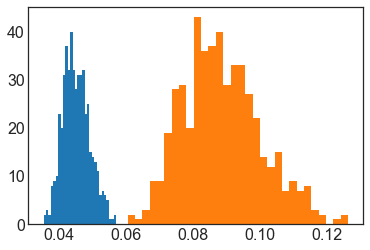

In [14]:
plt.hist(corr1k['dA1'],bins=30)
plt.hist(corr1k['da1'],bins=30)

(array([ 5.,  4., 10., 14., 21., 25., 39., 53., 49., 60., 52., 48., 33.,
        32., 17.,  8., 11., 10.,  4.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.03091649, 0.0319658 , 0.03301512, 0.03406443, 0.03511375,
        0.03616306, 0.03721238, 0.03826169, 0.03931101, 0.04036032,
        0.04140964, 0.04245895, 0.04350827, 0.04455758, 0.0456069 ,
        0.04665621, 0.04770553, 0.04875484, 0.04980416, 0.05085347,
        0.05190279, 0.0529521 , 0.05400142, 0.05505073, 0.05610005,
        0.05714936, 0.05819868, 0.05924799, 0.06029731, 0.06134662,
        0.06239594]),
 <BarContainer object of 30 artists>)

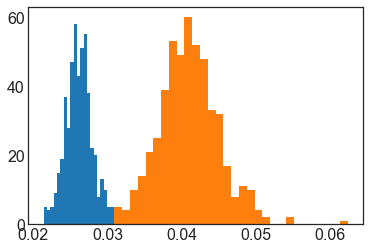

In [15]:
plt.hist(corr1k['dA2'],bins=30)
plt.hist(corr1k['da2'],bins=30)

In [16]:
print(corr1k['A1'].std()/corr1k['dA1'].mean())
print(corr1k['A2'].std()/corr1k['dA2'].mean())
print(corr1k['D'].std()/corr1k['dD'].mean())
print(corr1k['dA1dA2'].mean()/corr1k['da1da2'].mean())
print(corr1k['dA1dD'].mean()/corr1k['da1dd'].mean())
print(corr1k['dA2dD'].mean()/corr1k['dasdd'].mean())

1.8369039877466053
1.4984806509015334
1.1000765882472388
116.98000353611437
10.625006385138864
5.827928927779262


(array([ 1.,  0.,  2.,  1.,  6.,  6.,  9., 13., 19., 21., 30., 30., 46.,
        50., 58., 35., 44., 35., 31., 16., 14.,  9.,  8.,  7.,  3.,  2.,
         1.,  1.,  1.,  1.]),
 array([-2.59803960e-04, -2.41461243e-04, -2.23118526e-04, -2.04775809e-04,
        -1.86433092e-04, -1.68090375e-04, -1.49747658e-04, -1.31404941e-04,
        -1.13062224e-04, -9.47195067e-05, -7.63767896e-05, -5.80340726e-05,
        -3.96913556e-05, -2.13486386e-05, -3.00592157e-06,  1.53367955e-05,
         3.36795125e-05,  5.20222295e-05,  7.03649465e-05,  8.87076635e-05,
         1.07050381e-04,  1.25393098e-04,  1.43735815e-04,  1.62078532e-04,
         1.80421249e-04,  1.98763966e-04,  2.17106683e-04,  2.35449400e-04,
         2.53792117e-04,  2.72134834e-04,  2.90477551e-04]),
 <BarContainer object of 30 artists>)

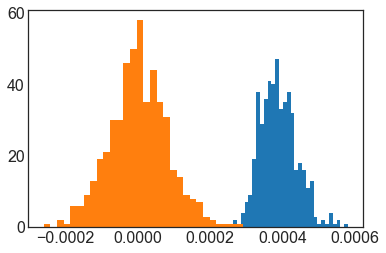

In [17]:
plt.hist(corr1k['dA1dA2'],bins=30)
plt.hist(corr1k['da1da2'],bins=30)

(array([ 1.,  0.,  0.,  1.,  4.,  2.,  6.,  5.,  9., 15., 15., 18., 28.,
        38., 37., 53., 45., 49., 43., 42., 22., 18., 28., 12.,  5.,  2.,
         1.,  0.,  0.,  1.]),
 array([-1.89916514e-04, -1.72988470e-04, -1.56060427e-04, -1.39132383e-04,
        -1.22204340e-04, -1.05276296e-04, -8.83482530e-05, -7.14202095e-05,
        -5.44921661e-05, -3.75641226e-05, -2.06360792e-05, -3.70803572e-06,
         1.32200077e-05,  3.01480512e-05,  4.70760946e-05,  6.40041381e-05,
         8.09321815e-05,  9.78602250e-05,  1.14788268e-04,  1.31716312e-04,
         1.48644355e-04,  1.65572399e-04,  1.82500442e-04,  1.99428486e-04,
         2.16356529e-04,  2.33284573e-04,  2.50212616e-04,  2.67140660e-04,
         2.84068703e-04,  3.00996746e-04,  3.17924790e-04]),
 <BarContainer object of 30 artists>)

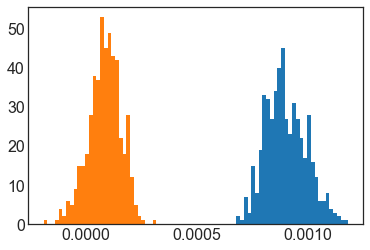

In [18]:
plt.hist(corr1k['dA1dD'],bins=30)
plt.hist(corr1k['da1dd'],bins=30)

(array([ 3.,  2.,  5.,  8., 12., 16., 20., 27., 13., 32., 37., 29., 44.,
        38., 29., 31., 27., 32., 29., 17., 15.,  8.,  4.,  5.,  6.,  4.,
         2.,  3.,  1.,  1.]),
 array([-2.18228191e-06,  4.10959162e-06,  1.04014652e-05,  1.66933387e-05,
         2.29852122e-05,  2.92770858e-05,  3.55689593e-05,  4.18608328e-05,
         4.81527064e-05,  5.44445799e-05,  6.07364534e-05,  6.70283270e-05,
         7.33202005e-05,  7.96120740e-05,  8.59039476e-05,  9.21958211e-05,
         9.84876946e-05,  1.04779568e-04,  1.11071442e-04,  1.17363315e-04,
         1.23655189e-04,  1.29947062e-04,  1.36238936e-04,  1.42530809e-04,
         1.48822683e-04,  1.55114556e-04,  1.61406430e-04,  1.67698303e-04,
         1.73990177e-04,  1.80282051e-04,  1.86573924e-04]),
 <BarContainer object of 30 artists>)

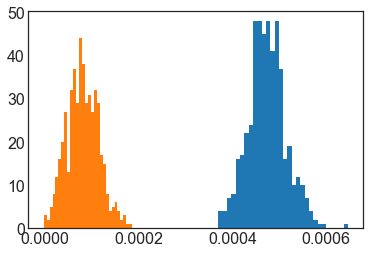

In [19]:
plt.hist(corr1k['dA2dD'],bins=30)
plt.hist(corr1k['dasdd'],bins=30)

[0.33471032 0.01560266]
factor of underestimation:  2.987658063492866


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


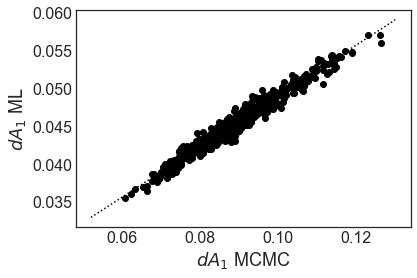

In [20]:
p1 = np.polyfit(corr1k['da1'],corr1k['dA1'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
da1 = np.linspace(0.052,0.13,200)
dA1 = p1[0]*da1 + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k['da1'],corr1k['dA1'],color="k")
plt.plot(da1,dA1,"k:")
plt.xlabel(r"$dA_1$ MCMC")
plt.ylabel(r"$dA_{1}$ ML")
plt.savefig("dA1corrkde025.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

[0.43712349 0.00822527]
factor of underestimation:  2.2876830410982283


/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "backgroundcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


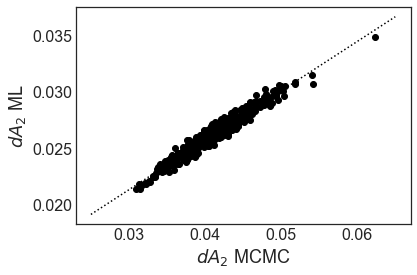

In [21]:
p1 = np.polyfit(corr1k['da2'],corr1k['dA2'],1)
print(p1)
print("factor of underestimation: ",1/p1[0])
da2 = np.linspace(0.025,0.065,200)
dA2 = p1[0]*da2 + p1[1]
plt.figure(facecolor="white")
plt.scatter(corr1k['da2'],corr1k['dA2'],color="k")
plt.plot(da2,dA2,"k:")
plt.xlabel(r"$dA_2$ MCMC")
plt.ylabel(r"$dA_{2}$ ML")
#plt.xlim((0.012,0.024))
#plt.ylim((0.01,0.018))
plt.savefig("dA2corrkde025.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [22]:
corr1k['dA2'].min()

0.021388061746507665